## NIMOハンズオン (関数の最適化)

In [9]:
import sys
sys.path.append('..')
import nimo

### AIとロボットのサイクルの回数を設定

In [10]:
CyclesNum = 15

### 目的関数の次元を設定

In [11]:
ObjectivesNum = 1

In [12]:
from al_mg_zn import AlMgZnMeltingPoint
des = AlMgZnMeltingPoint()

### 実験条件候補データファイル名および提案条件のファイル名を設定

In [13]:
from pathlib import Path
TRIAL = 1
BATCH_SIZE = 3
NTS_MODE = "aggressive"
if NTS_MODE == "conservative":
    MODE = nimo.Mode.conservative
elif NTS_MODE == "moderate":
    MODE = nimo.Mode.moderate
elif NTS_MODE == "aggressive":
    MODE = nimo.Mode.aggressive
print(MODE)
out_dir = Path(f"./data_{NTS_MODE}_{TRIAL}")
out_dir.mkdir(exist_ok=True, parents=True)
Path(f"./data_{NTS_MODE}_{TRIAL}/fig").mkdir(exist_ok=True, parents=True)

Mode.aggressive


In [14]:
candidates_file = f"./mp_search_space_nts_{NTS_MODE}_{TRIAL}.csv"

proposals_file = f"./mp_proposals_nts_{NTS_MODE}_{TRIAL}.csv"

### 結果を格納する場所を作成

In [15]:
res_history = nimo.history(input_file = candidates_file,
                             num_objectives = ObjectivesNum)

### 最適化計算

In [ ]:
import time
start = time.time()
for K in range(CyclesNum):

    #最初のサイクルではランダムに実験条件を提案させる
    if K == 0:
        nimo.selection(method = "RE",
                       input_file = candidates_file,
                       output_file = proposals_file,
                       num_objectives = ObjectivesNum,
                       num_proposals = BATCH_SIZE,
                       re_seed = 111)

    #2回目以降のサイクルではAIを使用して実験条件を提案
    #PHYSBO: ベイズ最適化
    #BLOX: 無目的探索
    #PDC: 相図探索
    #RE: ランダム
    else:
        nimo.selection(method = "NTS",
                       input_file = candidates_file,
                       output_file = proposals_file,
                       num_objectives = ObjectivesNum,
                       num_proposals = BATCH_SIZE,
                       sample_mode=MODE,
                       use_dpp=False,
                       output_res=True)

    #実験条件に従い，ロボット実験のインプットファイルを作成する
    #今回は，inputfile.txtファイルを作成するだけのモジュール
    import preparation_input_functions
    preparation_input_functions.ORIGINAL(input_file = proposals_file,
                                         input_folder = "./").perform()


    #実験終了後，測定データを解析し，目的関数をアップデートする
    #今回は，関数値を計算し，目的関数とするanalysis_output_functions.pyを利用する
    import analysis_output_functions_SO_melting_point
    analysis_output_functions_SO_melting_point.ORIGINAL(input_file = proposals_file,
                                       output_file = candidates_file,
                                       num_objectives = ObjectivesNum,
                                       output_folder = f"./data_{NTS_MODE}_{TRIAL}").perform()

    #結果をプロットするためのhistoryを格納する
    res_history = nimo.history(input_file = candidates_file,
                               num_objectives = ObjectivesNum,
                               itt = K,
                               history_file = res_history)

    #結果のヒストグラムを作成するモジュールを読み出す
    if K % 5 == 0:
        import time
        time.sleep(1)
        nimo.visualization.plot_distribution.plot(input_file = candidates_file,
                                                  num_objectives = ObjectivesNum,
                                                  fig_folder = f"./data_{NTS_MODE}_{TRIAL}/fig")

    #結果の相図を作成するモジュールを読み出す
    #if K % 5 == 0:
    #    import time
    #    time.sleep(1)
    #    nimo.visualization.plot_phase_diagram.plot(input_file = candidates_file,
    #                                               fig_folder = "./fig")
end = time.time()
print(f"Elapsed time: {end - start} [s]")

Start selection of proposals by RE!
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214

### 目的関数の推移を出力

In [17]:
nimo.visualization.plot_history.cycle(input_file = res_history,
                                      num_cycles = CyclesNum,
                                      fig_folder = f"./data_{NTS_MODE}_{TRIAL}/fig")

In [18]:
import numpy as np
tmp = []
X_tmp = []
for r in res_history:
    tmp.append(r[2][0])
    X_tmp.append(r[1])

tmp = np.array(tmp)
X_tmp = np.array(X_tmp)

In [19]:
from collections import defaultdict
sample_by_iter, objective_by_iter = defaultdict(list), defaultdict(list)
for r in res_history:
    objective_by_iter[r[0]].append(r[2][0])
    sample_by_iter[r[0]].append(r[1])

dict_keys([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15])


Text(0, 0.5, 'Objective')

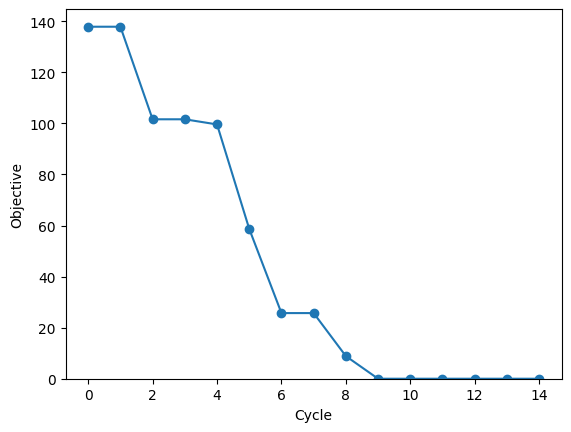

In [20]:
import matplotlib.pyplot as plt

print(objective_by_iter.keys())

fig, ax = plt.subplots()
tmp_history = [des.get_regret(max(objective_by_iter[1]))]
for i in range(1, CyclesNum):
    tmp_history.append(min(tmp_history[-1], des.get_regret(max(objective_by_iter[i]))))
ax.plot(range(CyclesNum), tmp_history, marker="o")
ax.set_xlabel("Cycle")
ax.set_ylim(0)
ax.set_ylabel("Objective")

In [21]:
# Save nested list object
import pickle
with open(out_dir / "objective_by_iter.pkl", "wb") as f:
    pickle.dump(objective_by_iter, f)
with open(out_dir / "sample_by_iter.pkl", "wb") as f:
    pickle.dump(sample_by_iter, f)